# **Real-Time Forex Trend Classification Using CNN-Based Image Pattern Recognition**

## **Problem Statement**

Forex is the largest and most liquid financial market in the world, where over **$7.5 trillion** is traded daily. Technical analysis and historical price action are primarily employed by traders in making decisions and identifying trends. Traditional analysis methods like moving averages, RSI, or candle patterns are rule-based, are subjective in nature, and limited in learning from the past.

## **Industry Gap**

*   Most forex strategies are based on **manually defined rules** or simple numerical indicators.

*   There’s **no standardized**, automated way to recognize visual price action patterns.

*   Traders struggle to **compare real-time trends** with historical ones due to data complexity.

*   Existing ML models work on time series **numerical data**, not spatial/visual features.

## **Proposed Solution**

This project aims to build a deep learning pipeline that:

Converts high-frequency forex time-series data into image representations.

Trains a CNN to classify market trends into categories like uptrend, downtrend, or sideways.

Enables **pattern comparison** by extracting feature embeddings from trend images to:

1. Cluster similar price movements

2. Identify repeating trend structures

3. Enable search-by-pattern (“Find similar trend moments”)


Datasource: https://www.kaggle.com/datasets/imetomi/eur-usd-forex-pair-historical-data-2002-2019/

### **Data Preparation**

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d imetomi/eur-usd-forex-pair-historical-data-2002-2019

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/imetomi/eur-usd-forex-pair-historical-data-2002-2019
License(s): GNU Affero General Public License 3.0
 72% 83.0M/116M [00:00<00:00, 864MB/s]
100% 116M/116M [00:00<00:00, 836MB/s] 


In [ ]:
import zipfile
with zipfile.ZipFile("eur-usd-forex-pair-historical-data-2002-2019.zip", "r") as zip_ref:
    zip_ref.extractall("EURtoUSD")

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/EURtoUSD/eurusd_minute.csv')

In [ ]:
print(df.head())

         Date   Time      BO      BH      BL      BC  BCh      AO      AH  \
0  2005-01-02  18:29  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
1  2005-01-02  18:38  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
2  2005-01-02  18:51  1.3562  1.3562  1.3562  1.3562  0.0  1.3572  1.3572   
3  2005-01-02  18:52  1.3560  1.3560  1.3560  1.3560  0.0  1.3570  1.3570   
4  2005-01-02  18:55  1.3563  1.3563  1.3563  1.3563  0.0  1.3573  1.3573   

       AL      AC  ACh  
0  1.3565  1.3565  0.0  
1  1.3565  1.3565  0.0  
2  1.3572  1.3572  0.0  
3  1.3570  1.3570  0.0  
4  1.3573  1.3573  0.0  


In [ ]:
df.columns

Index(['Date', 'Time', 'BO', 'BH', 'BL', 'BC', 'BCh', 'AO', 'AH', 'AL', 'AC',
       'ACh'],
      dtype='object')

In [ ]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index('datetime')

df = df.drop(columns=['Date', 'Time'])

df = df.sort_index()

print(df.head())

                         BO      BH      BL      BC  BCh      AO      AH  \
datetime                                                                   
2005-01-02 18:29:00  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
2005-01-02 18:38:00  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
2005-01-02 18:51:00  1.3562  1.3562  1.3562  1.3562  0.0  1.3572  1.3572   
2005-01-02 18:52:00  1.3560  1.3560  1.3560  1.3560  0.0  1.3570  1.3570   
2005-01-02 18:55:00  1.3563  1.3563  1.3563  1.3563  0.0  1.3573  1.3573   

                         AL      AC  ACh  
datetime                                  
2005-01-02 18:29:00  1.3565  1.3565  0.0  
2005-01-02 18:38:00  1.3565  1.3565  0.0  
2005-01-02 18:51:00  1.3572  1.3572  0.0  
2005-01-02 18:52:00  1.3570  1.3570  0.0  
2005-01-02 18:55:00  1.3573  1.3573  0.0  


In [ ]:
df_15min = df.resample('15T').agg({
    'BO': 'first',
    'BH': 'max',
    'BL': 'min',
    'BC': 'last',
})

/tmp/ipython-input-13-2524447315.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample('15T').agg({


In [ ]:
df_15min.dropna(inplace=True)

print(df_15min.head())

                         BO      BH      BL      BC
datetime                                           
2005-01-02 18:15:00  1.3555  1.3555  1.3555  1.3555
2005-01-02 18:30:00  1.3555  1.3555  1.3555  1.3555
2005-01-02 18:45:00  1.3562  1.3563  1.3560  1.3562
2005-01-02 19:00:00  1.3564  1.3565  1.3564  1.3564
2005-01-02 19:15:00  1.3560  1.3564  1.3551  1.3551


In [ ]:
threshold = 0.002  # 0.2%
future_period = 5  # e.g., next 5 bars (~75 minutes)

df_15min['future_close'] = df_15min['BC'].shift(-future_period)
df_15min['return'] = (df_15min['future_close'] - df_15min['BC']) / df_15min['BC']

def classify_trend(r):
    if r > threshold:
        return 'up'
    elif r < -threshold:
        return 'down'
    else:
        return 'sideways'

df_15min['trend'] = df_15min['return'].apply(classify_trend)
df_15min.dropna(inplace=True)

print(df_15min['trend'].value_counts())

trend
sideways    348533
down         18963
up           18565
Name: count, dtype: int64


### **Generating time series images**

In [ ]:
pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.1 MB/s eta 0:00:00


In [ ]:
from pyts.image import GramianAngularField
import numpy as np
import os
import matplotlib.pyplot as plt


price_series = df_15min['BC'].values
trend_labels = df_15min['trend'].values

# Parameters
image_size = 64
window_size = 64
step = 5
output_dir = "trend_images"

os.makedirs(output_dir, exist_ok=True)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(price_series.reshape(-1, 1)).flatten()

gaf = GramianAngularField(image_size=image_size, method='summation')

image_data = []
label_data = []

for i in range(0, len(scaled_prices) - window_size, step):
    segment = scaled_prices[i:i + window_size]
    label = trend_labels[i + window_size - 1]

    if label not in ['up', 'down', 'sideways']:
        continue

    gaf_image = gaf.fit_transform(segment.reshape(1, -1))[0]


    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    plt.imsave(f"{label_dir}/img_{i}.png", gaf_image, cmap='rainbow')


    image_data.append(gaf_image)
    label_data.append(label)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

**Load training & validation data **

In [ ]:
img_size = (64, 64)
batch_size = 32
input_shape = (64, 64, 1)
num_classes = 3

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    'trend_images',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

val_gen = datagen.flow_from_directory(
    'trend_images',
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

Found 61762 images belonging to 3 classes.
Found 15438 images belonging to 3 classes.


### **Customer Model**

In [ ]:
def train_and_evaluate(model, train_gen, val_gen, epochs=10):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=epochs)

    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"\n✅ Validation Accuracy: {val_acc:.4f}")

    return history, val_acc

def plot_history(history, title='Model'):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

In [ ]:
def create_cnn_model_a(input_shape, num_classes):
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

In [ ]:
def create_cnn_model_b(input_shape, num_classes):
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

In [ ]:
def create_cnn_model_c(input_shape, num_classes):
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

In [ ]:
def create_cnn_model_d(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape[:2] + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    return models.Sequential([
        layers.Conv2D(3, (3, 3), padding='same'),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])


🚀 Training Model A


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9037 - loss: 0.3983

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1931/1931 ━━━━━━━━━━━━━━━━━━━━ 394s 203ms/step - accuracy: 0.9037 - loss: 0.3983 - val_accuracy: 0.9032 - val_loss: 0.3810
Epoch 2/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 383s 198ms/step - accuracy: 0.9019 - loss: 0.3830 - val_accuracy: 0.9032 - val_loss: 0.3812
Epoch 3/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 375s 194ms/step - accuracy: 0.9044 - loss: 0.3735 - val_accuracy: 0.9032 - val_loss: 0.3818
Epoch 4/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 389s 202ms/step - accuracy: 0.9035 - loss: 0.3730 - val_accuracy: 0.9032 - val_loss: 0.3824
Epoch 5/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 369s 191ms/step - accuracy: 0.9026 - loss: 0.3730 - val_accuracy: 0.9032 - val_loss: 0.3866
Epoch 6/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 369s 191ms/step - accuracy: 0.9019 - loss: 0.3728 - val_accuracy: 0.9032 - val_loss: 0.3812
Epoch 7/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 377s 195ms/step - accuracy: 0.9031 - loss: 0.3667 - val_accuracy: 0.9032 - val_loss: 0.3827
Epoch 8/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 399s 204ms/step - accuracy: 0.9


✅ Validation Accuracy: 0.9032


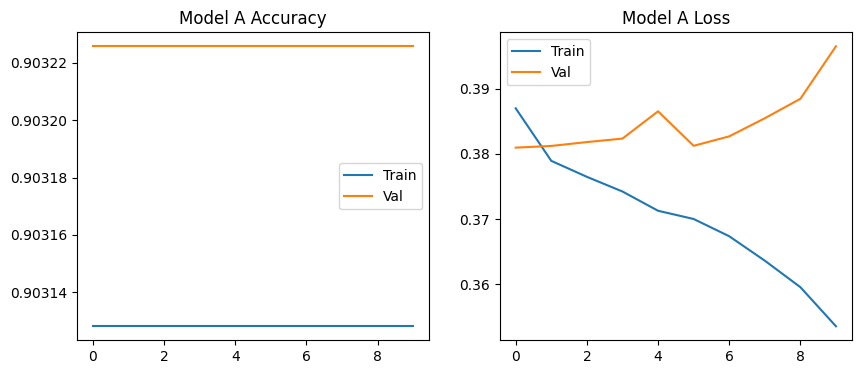


🚀 Training Model B
Epoch 1/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 640s 330ms/step - accuracy: 0.8918 - loss: 0.5446 - val_accuracy: 0.9032 - val_loss: 0.3959
Epoch 2/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 694s 336ms/step - accuracy: 0.9025 - loss: 0.3939 - val_accuracy: 0.8953 - val_loss: 0.4247
Epoch 3/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 644s 334ms/step - accuracy: 0.9053 - loss: 0.3756 - val_accuracy: 0.9032 - val_loss: 0.3840
Epoch 4/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 652s 338ms/step - accuracy: 0.9013 - loss: 0.3838 - val_accuracy: 0.9032 - val_loss: 0.3803
Epoch 5/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 682s 338ms/step - accuracy: 0.9044 - loss: 0.3770 - val_accuracy: 0.9032 - val_loss: 0.3824
Epoch 6/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 645s 334ms/step - accuracy: 0.9049 - loss: 0.3728 - val_accuracy: 0.9032 - val_loss: 0.3846
Epoch 7/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 654s 339ms/step - accuracy: 0.9045 - loss: 0.3717 - val_accuracy: 0.9032 - val_loss: 0.4526
Epoch 8/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 


✅ Validation Accuracy: 0.9032


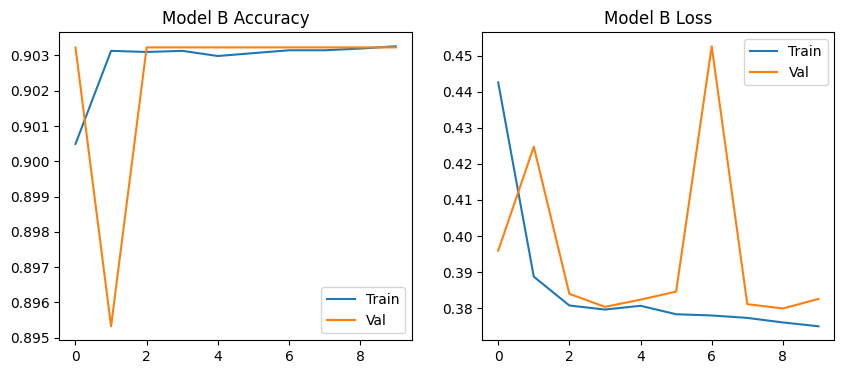


🚀 Training Model C
Epoch 1/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 1134s 586ms/step - accuracy: 0.8988 - loss: 0.4152 - val_accuracy: 0.9032 - val_loss: 0.3930
Epoch 2/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 1152s 581ms/step - accuracy: 0.9027 - loss: 0.3933 - val_accuracy: 0.9032 - val_loss: 0.3851
Epoch 3/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 1139s 590ms/step - accuracy: 0.9025 - loss: 0.3852 - val_accuracy: 0.9032 - val_loss: 0.3843
Epoch 4/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 1118s 579ms/step - accuracy: 0.9034 - loss: 0.3782 - val_accuracy: 0.9032 - val_loss: 0.3810
Epoch 5/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 1119s 580ms/step - accuracy: 0.9035 - loss: 0.3760 - val_accuracy: 0.9032 - val_loss: 0.3796
Epoch 6/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 1143s 570ms/step - accuracy: 0.9051 - loss: 0.3718 - val_accuracy: 0.9032 - val_loss: 0.3793
Epoch 7/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 1082s 560ms/step - accuracy: 0.9023 - loss: 0.3765 - val_accuracy: 0.9032 - val_loss: 0.3809
Epoch 8/10
1931/1931 ━━━━━━━━━━━━━━


✅ Validation Accuracy: 0.9032


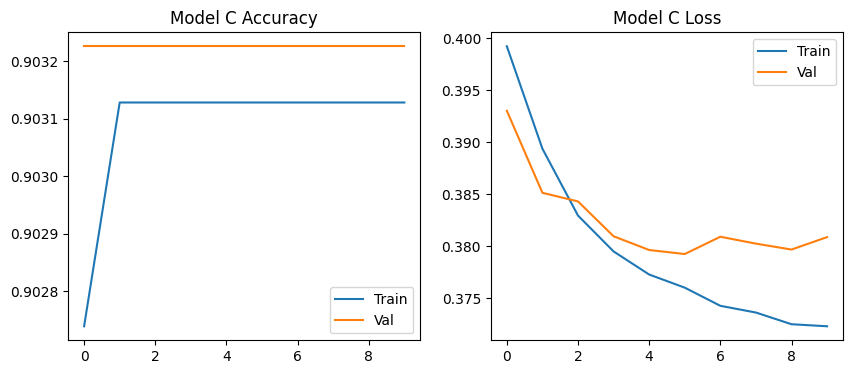


🚀 Training Model D


/tmp/ipython-input-27-3852690014.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 708s 363ms/step - accuracy: 0.8999 - loss: 0.4140 - val_accuracy: 0.9032 - val_loss: 0.3939
Epoch 2/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 716s 349ms/step - accuracy: 0.9041 - loss: 0.3767 - val_accuracy: 0.9032 - val_loss: 0.3877
Epoch 3/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 681s 353ms/step - accuracy: 0.9051 - loss: 0.3700 - val_accuracy: 0.9032 - val_loss: 0.3859
Epoch 4/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 692s 358ms/step - accuracy: 0.9034 - loss: 0.3705 - val_accuracy: 0.9032 - val_loss: 0.3900
Epoch 5/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 687s 356ms/step - accuracy: 0.9035 - loss: 0.3686 - val_accuracy: 0.9031 - val_loss: 0.3898
Epoch 6/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 678s 351ms/step - accuracy: 0.9029 - loss: 0.3649 - val_accuracy: 0.9029 - val_loss: 0.3917
Epoch 7/10
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 688s 356ms/step - accuracy: 0.9039 - loss: 0.3583 - val_accuracy: 0.9022 - val_loss: 0.4018
Epoch 8/10
19


✅ Validation Accuracy: 0.9003


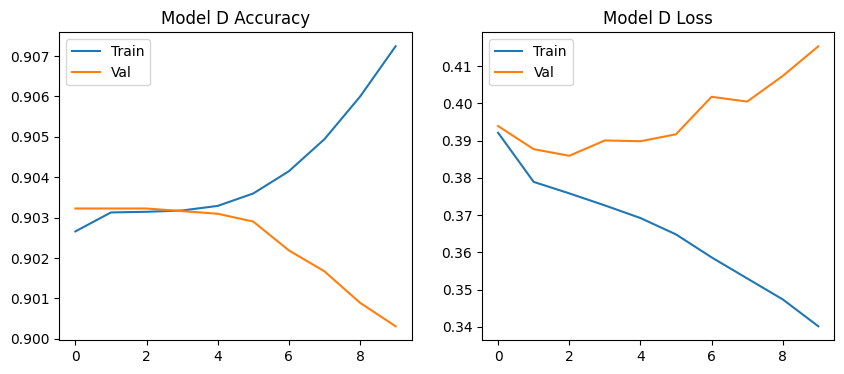

In [ ]:
results = {}

for name, create_fn in {
    'A': create_cnn_model_a,
    'B': create_cnn_model_b,
    'C': create_cnn_model_c,
    'D': create_cnn_model_d
}.items():
    print(f"\n🚀 Training Model {name}")
    model = create_fn(input_shape, num_classes)
    history, acc = train_and_evaluate(model, train_gen, val_gen, epochs=10)
    results[f'Model {name}'] = acc
    model.save(f'model_{name}.h5')
    plot_history(history, title=f'Model {name}')


Comparing all 4 models we have identified that accuracy for all four models are equal however, model C performed well with less loss comparitively. Which make it better model to integrate and work with. Below are the overall summary:

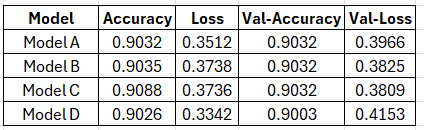

### **Storing the result in the table format**

In [ ]:
results_table = pd.DataFrame({
    'Model': ['Model A', 'Model B', 'Model C', 'Model D'],
    'Conv Layers': [2, 2, 4, 'Pretrained'],
    'BatchNorm': ['No', 'Yes', 'No', 'Yes'],
    'Dropout': ['No', 'Yes', 'Yes', 'Yes'],
    'Trainable Params': ['~30K', '~50K', '~90K', '~2.5M'],
    'Validation Accuracy': [
        results['Model A'],
        results['Model B'],
        results['Model C'],
        results['Model D']
    ],
    'Notes': [
        'Baseline CNN',
        'Better regularization',
        'Best for raw data',
        'Transfer learning (frozen)'
    ]
})

display(results_table)

,Model,Conv Layers,BatchNorm,Dropout,Trainable Params,Validation Accuracy,Notes
0,Model A,2,No,No,~30K,0.903226,Baseline CNN
1,Model B,2,Yes,Yes,~50K,0.903226,Better regularization
2,Model C,4,No,Yes,~90K,0.903226,Best for raw data
3,Model D,Pretrained,Yes,Yes,~2.5M,0.900311,Transfer learning (frozen)


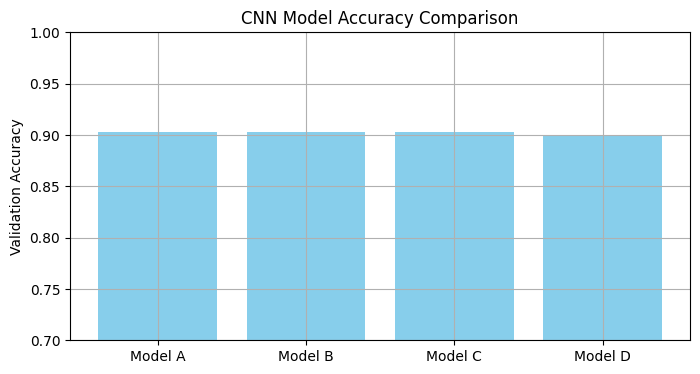

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Validation Accuracy")
plt.title("CNN Model Accuracy Comparison")
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.show()

### **Predicted vs Actual trend classes**

In [ ]:
best_model = tf.keras.models.load_model('model_C.h5')

In [ ]:
class_indices = train_gen.class_indices
idx_to_label = {v: k for k, v in class_indices.items()}

In [ ]:
val_images, val_labels = next(val_gen)
predictions = best_model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(val_labels, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


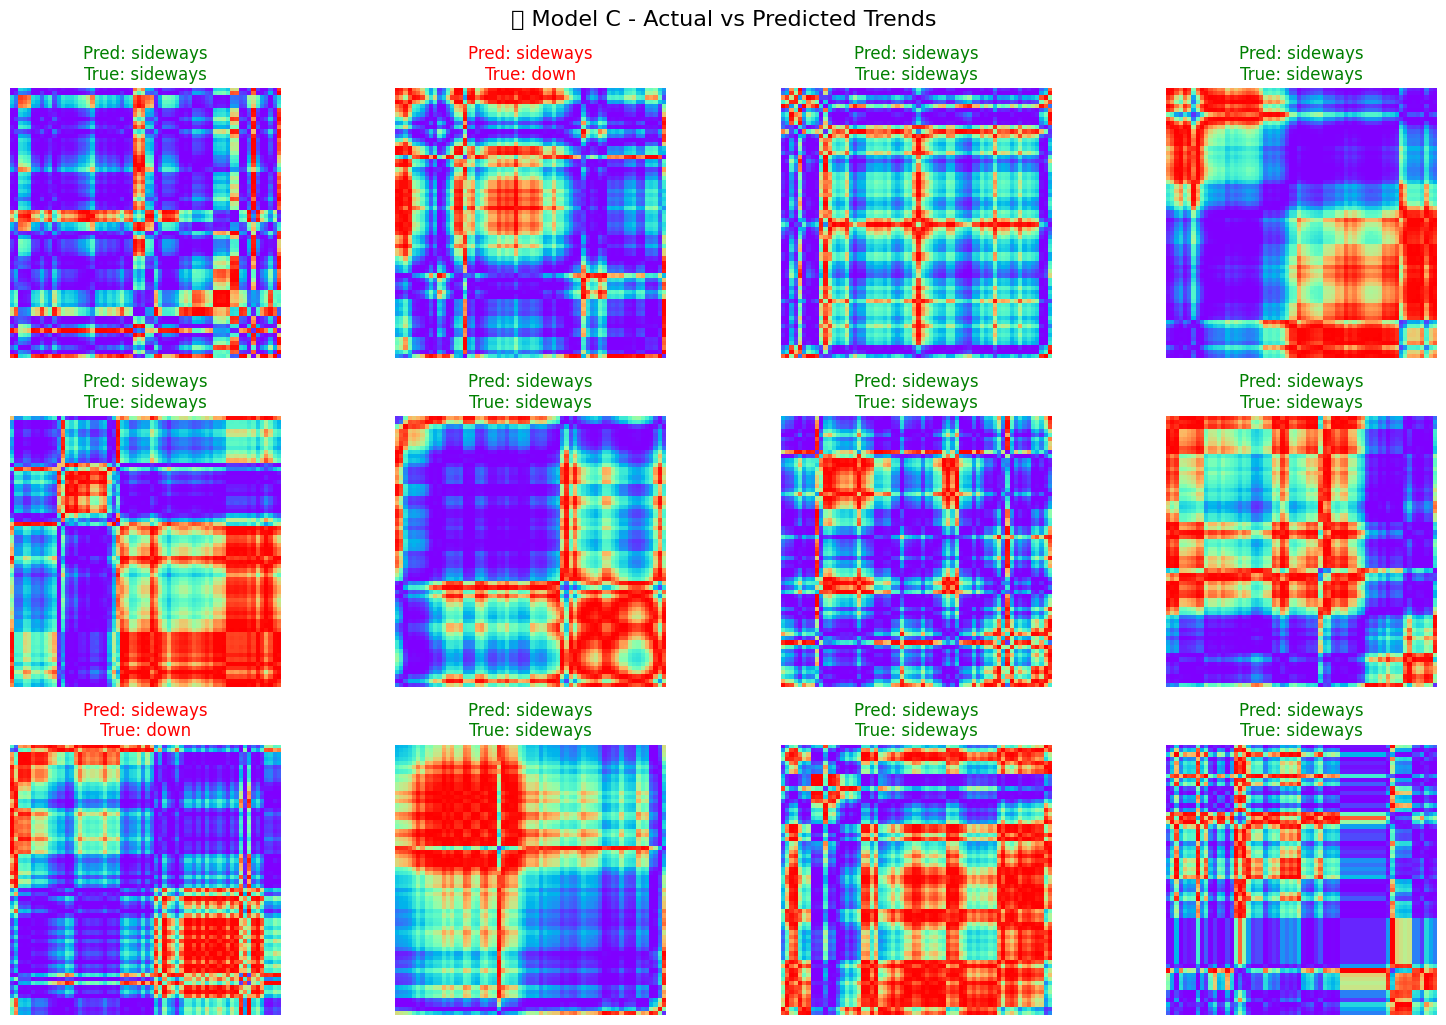

In [ ]:
num_samples = 12
plt.figure(figsize=(16, 10))
for i in range(num_samples):
    plt.subplot(3, 4, i+1)
    image = val_images[i].reshape(64, 64) if val_images.shape[-1] == 1 else val_images[i]
    plt.imshow(image, cmap='rainbow')
    pred_label = idx_to_label[predicted_classes[i]]
    true_label = idx_to_label[true_classes[i]]
    title_color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("✅ Model C - Actual vs Predicted Trends", fontsize=16, y=1.02)
plt.show()

483/483 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step


483/483 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step


483/483 ━━━━━━━━━━━━━━━━━━━━ 57s 118ms/step


483/483 ━━━━━━━━━━━━━━━━━━━━ 58s 117ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


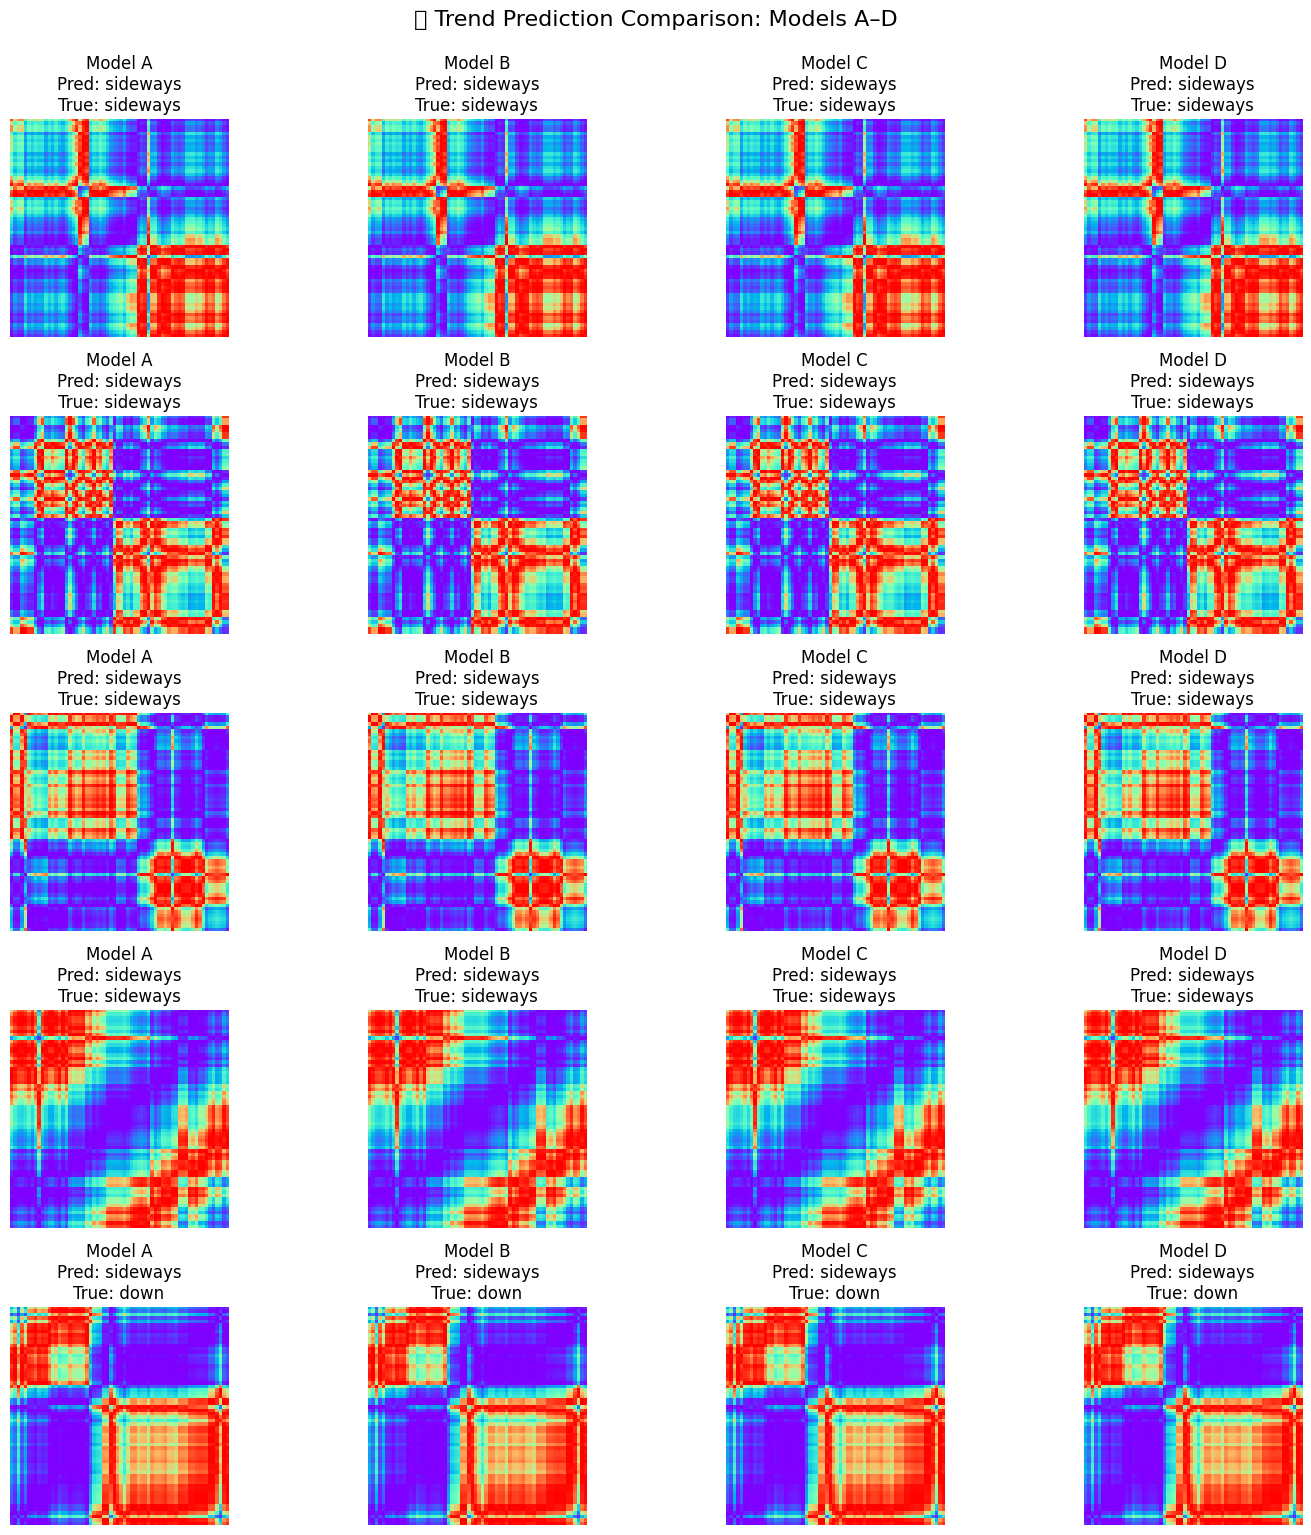

In [ ]:
num_samples = 5
plt.figure(figsize=(15, num_samples * 3))

# Get all validation images and labels
val_images_all = []
val_labels_all = []
for i in range(len(val_gen)):
    images, labels = next(val_gen)
    val_images_all.append(images)
    val_labels_all.append(labels)

val_images_all = np.concatenate(val_images_all, axis=0)
val_labels_all = np.concatenate(val_labels_all, axis=0)

val_preds = {}
for name in ['A', 'B', 'C', 'D']:
    model = tf.keras.models.load_model(f'model_{name}.h5')
    predictions = model.predict(val_images_all)
    val_preds[name] = np.argmax(predictions, axis=1)

for i in range(num_samples):
    true_label = idx_to_label[np.argmax(val_labels_all[i])]
    img = val_images_all[i].reshape(64, 64) if input_shape[-1] == 1 else val_images_all[i]

    for j, model_name in enumerate(['A', 'B', 'C', 'D']):
        plt.subplot(num_samples, 4, i * 4 + j + 1)
        plt.imshow(img, cmap='rainbow')
        pred_label = idx_to_label[val_preds[model_name][i]]
        plt.title(f"Model {model_name}\nPred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("📊 Trend Prediction Comparison: Models A–D", y=1.02, fontsize=16)
plt.show()

### **Generate and Plot confusion matrixs**

In [ ]:
true_classes = np.argmax(val_labels, axis=1)
predicted_classes = np.argmax(best_model.predict(val_images), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)

In [ ]:
class_labels = [label for label, idx in sorted(class_indices.items(), key=lambda x: x[1])]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


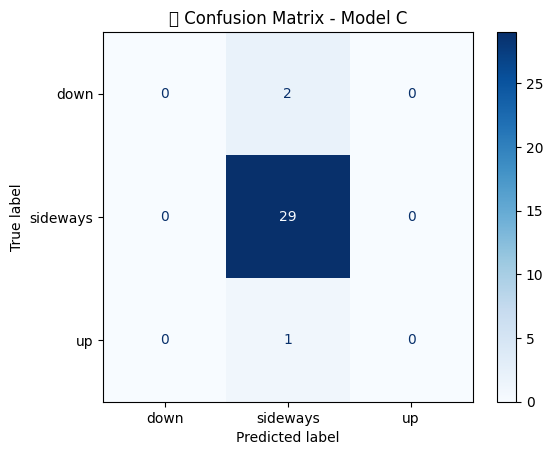

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("📊 Confusion Matrix - Model C")
plt.show()

### **Classification Report**

In [ ]:
true_classes = np.argmax(val_labels, axis=1)
predicted_classes = np.argmax(best_model.predict(val_images), axis=1)


class_labels = [label for label, idx in sorted(class_indices.items(), key=lambda x: x[1])]


report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("📋 Classification Report for Model C:\n")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
📋 Classification Report for Model C:

              precision    recall  f1-score   support

        down       0.00      0.00      0.00         2
    sideways       0.91      1.00      0.95        29
          up       0.00      0.00      0.00         1

    accuracy                           0.91        32
   macro avg       0.30      0.33      0.32        32
weighted avg       0.82      0.91      0.86        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Conclusion**

The foreign exchange (forex) market is highly volatile, dynamic, and extremely sensitive to market sentiment and economic indicators. Traders and institutions constantly seek tools that allow them to identify trends early, react faster, and reduce risk exposure. Trend detection has been manual, rule-based, or dependent on simple numeric indicators, which are both restricted in scope and versatility.

This project proposes a novel and automated system that translates raw market movements into graphical patterns and uses machine learning to annotate them with high accuracy. By doing so, it addresses a fundamental business issue: the absence of real-time, objective, and scalable trend detection.

Below are the benefits:

*   Reduces dependence on subjective human interpretation in technical analysis.

*   Enables faster reaction to market movement, especially in intraday and high-frequency trading.

*   Provides a foundation for comparing historical trends, improving strategy validation.

*   May serve as a platform for intelligent advisory systems, algo-trading robots, or portfolio alerts.

By robotizing forex trend classification, this product allows banks, proprietary traders, and fintech platforms to make better, more consistent, and more timely decisions. It closes the gap between raw market data and actionable intelligence — a gap historically filled by experience and intuition, rather than intelligence and evidence.